In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt

### load dataset

In [2]:
df = pd.read_csv("model_outcome.csv", index_col = 0)
df.head()

,class,predicted_prob
index,,
1,0,0.592837
2,1,0.624829
3,0,0.073848
4,1,0.544891
5,0,0.015118


### create 'predicted' column: 1 if predicted_prob >= 0.5, 0 else

In [3]:
df['predicted'] = df['predicted_prob'].apply(lambda x: 1 if x >= 0.5 else 0)

### define confusion matrix

In [4]:
def confusion_matrix(truth_arr, pred_arr):
    arr = [[0, 0], [0, 0]]

    for i in range(len(truth_arr)):
        if truth_arr[i] == 0:
            if pred_arr[i] == 0:
                # True Negative
                arr[0][0] += 1
            else:
                # False Positive
                arr[1][0] += 1 
                    
        elif truth_arr[i] == 1:
            if pred_arr[i] == 1:
                # True Positive
                arr[1][1] += 1
            else:
                # False Negative
                arr[0][1] += 1

    return arr

In [5]:
conf_arr = confusion_matrix(df['class'].values, df['predicted'].values)
print("confusion matrix\n", conf_arr)
# [[TN FN], [FP TP]]

confusion matrix
 [[385, 90], [123, 402]]


# 1. Sensitivity and Specificity 

In [6]:
# sensitivity = TP / (TP + FN)
sensitivity = round(conf_arr[1][1] / (conf_arr[1][1] + conf_arr[0][1]), 2)

# specificity = TN / (TN + FP)
specificity = round(conf_arr[0][0] / (conf_arr[0][0] + conf_arr[1][0]), 2)

print("Sensitivity: {0}\nSpecificity: {1}".format(sensitivity, specificity))

Sensitivity: 0.82
Specificity: 0.76


# 2. Area Under the Receiver Operating Characteristic Curve

### step 1. calculate False Positive Rate(FPR) and True Positive Rate(TPR) vectors

In [7]:
# sort df by predicted_prob in descending order
df_roc = df.copy().sort_values(by = ['predicted_prob'], ascending=False)
df_roc.head(15)

,class,predicted_prob,predicted
index,,,
705,1,0.994258,1
138,1,0.993762,1
630,1,0.993762,1
810,1,0.993454,1
318,1,0.993454,1
616,1,0.991934,1
653,1,0.991386,1
161,1,0.991386,1
369,1,0.990895,1


In [8]:
# calculate FPR and TPR by decreasing threshold 
TPR, FPR = [], []
TP, FP = 0, 0
for i in range(len(df_roc)):
    if df_roc.iloc[i]['class'] == 1:
        TP, FP = TP+1, FP
    else:
        TP, FP = TP, FP+1
    
    TPR.append(TP/df_roc['class'].sum())
    FPR.append(FP/(df_roc['class'].count()-df_roc['class'].sum()))

In [9]:
# store FPR and TPR in dataframe
d = {'FPR': FPR, 'TPR': TPR}
df_fpr_tpr = DataFrame(data=d)

### step 2. calculate the area

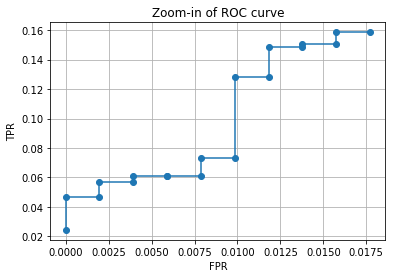

In [10]:
# decompose FPR, TPR curve into many rectangulars 
s = df_fpr_tpr.groupby(['FPR'])['TPR'].max()

plt.step(s.index[:10], s.values[:10], 'C0o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Zoom-in of ROC curve')
plt.grid()
plt.show()

In [11]:
# calculate the area under each rectangular, and accumulate them to get AUC 
delta_x = (s.index[1:-1] - s.index[:-2]).values
delta_y = s.values[:-2]
print("Area Under ROC curve:", round(sum(delta_x * delta_y), 2))

Area Under ROC curve: 0.89


# 3. Visualization of Receiver Operating Characteristic Curve 

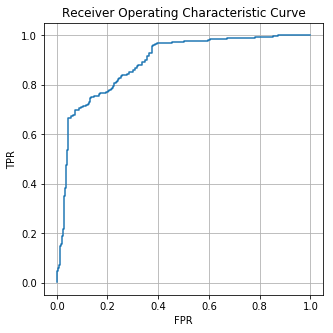

In [12]:
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic Curve')
plt.grid()
plt.show()